In [75]:
import matplotlib.pyplot as plt

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


## Reformat into a TensorFlow-friendly shape:

convolutions need the image data formatted as a cube (width by height by #channels)
labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

##### Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally,  so we'll limit its depth and number of fully connected nodes.

In [20]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) #16*28*28*1
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))#16*10
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) #5*5*1*16
  layer1_biases = tf.Variable(tf.zeros([depth])) #16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1)) #5*5*16*16
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))  #16
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))  #784*64
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden])) #64
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1)) #784*10
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels])) #10
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')#注意stride是看patch左边位置在原图形中一直滑行到最后的次数，same不全最后一次滑行
    print('data',data.get_shape().as_list())
    print(layer1_weights.get_shape().as_list())
    print(conv.get_shape().as_list())#此处padding方法参考https://www.cnblogs.com/wuzhitj/p/6433871.html
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

data [16, 28, 28, 1]
[5, 5, 1, 16]
[16, 14, 14, 16]
data [10000, 28, 28, 1]
[5, 5, 1, 16]
[10000, 14, 14, 16]
data [10000, 28, 28, 1]
[5, 5, 1, 16]
[10000, 14, 14, 16]


In [107]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.952186
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.754473
Minibatch accuracy: 37.5%
Validation accuracy: 53.1%
Minibatch loss at step 100: 0.907926
Minibatch accuracy: 62.5%
Validation accuracy: 71.3%
Minibatch loss at step 150: 0.941217
Minibatch accuracy: 75.0%
Validation accuracy: 75.7%
Minibatch loss at step 200: 0.378144
Minibatch accuracy: 93.8%
Validation accuracy: 78.2%
Minibatch loss at step 250: 0.988107
Minibatch accuracy: 56.2%
Validation accuracy: 77.3%
Minibatch loss at step 300: 0.883856
Minibatch accuracy: 81.2%
Validation accuracy: 79.6%
Minibatch loss at step 350: 1.073007
Minibatch accuracy: 68.8%
Validation accuracy: 78.6%
Minibatch loss at step 400: 0.703866
Minibatch accuracy: 81.2%
Validation accuracy: 78.3%
Minibatch loss at step 450: 0.568817
Minibatch accuracy: 81.2%
Validation accuracy: 79.1%
Minibatch loss at step 500: 0.581583
Minibatch accuracy: 81.2%
Validation accuracy: 79.9%
Mi

## Problem 1
The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.

In [11]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) #16*28*28*1
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))#16*10
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) #5*5*1*16
  layer1_biases = tf.Variable(tf.zeros([depth])) #16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1)) #5*5*16*16
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))  #16
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 , num_hidden], stddev=0.1))  #784*64
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden])) #64
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1)) #784*10
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels])) #10
  
  # Model.
  def model(data):
    pool1 = tf.nn.max_pool(data,[1,2,2,1],2,padding='SAME')
    pool2 = tf.nn.max_pool(pool1,[1,2,2,1],2,padding='SAME')
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [12]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.894032
Minibatch accuracy: 0.0%
Validation accuracy: 11.0%
Minibatch loss at step 50: 1.897195
Minibatch accuracy: 37.5%
Validation accuracy: 38.2%
Minibatch loss at step 100: 1.569183
Minibatch accuracy: 56.2%
Validation accuracy: 57.0%
Minibatch loss at step 150: 1.251963
Minibatch accuracy: 75.0%
Validation accuracy: 66.6%
Minibatch loss at step 200: 1.110767
Minibatch accuracy: 68.8%
Validation accuracy: 71.8%
Minibatch loss at step 250: 1.201090
Minibatch accuracy: 68.8%
Validation accuracy: 71.2%
Minibatch loss at step 300: 0.975795
Minibatch accuracy: 75.0%
Validation accuracy: 73.8%
Minibatch loss at step 350: 0.995811
Minibatch accuracy: 68.8%
Validation accuracy: 73.2%
Minibatch loss at step 400: 0.800678
Minibatch accuracy: 68.8%
Validation accuracy: 74.0%
Minibatch loss at step 450: 0.694021
Minibatch accuracy: 81.2%
Validation accuracy: 74.0%
Minibatch loss at step 500: 0.998774
Minibatch accuracy: 68.8%
Validation accuracy: 75.0%
Mi

## Problem 2
Try to get the best performance you can using a convolutional net. Look for example at the classic LeNet5 architecture, adding Dropout, and/or adding learning rate decay.

In [119]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels)) #16*28*28*1
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))#16*10
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1)) #5*5*1*16
  layer1_biases = tf.Variable(tf.zeros([depth])) #16
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, 300], stddev=0.1)) #5*5*16*16
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[300]))  #16
  layer3_weights = tf.Variable(tf.truncated_normal(
      [300 , 150], stddev=0.1))  #784*64
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[150])) #64
  layer4_weights = tf.Variable(tf.truncated_normal(
      [150, num_labels], stddev=0.1)) #784*10
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels])) #10
  
  # Model.
  def model(data):
    pool1 = tf.nn.avg_pool(data,[1,2,2,1],2,padding='VALID')
    conv = tf.nn.conv2d(pool1,layer1_weights,1,padding='VALID')
    hidden = tf.nn.tanh(conv + layer1_biases)
    pool2 = tf.nn.avg_pool(hidden,[1,2,2,1],2,padding='VALID')
    conv = tf.nn.conv2d(pool2,layer2_weights,1,padding='VALID')
    hidden = tf.nn.tanh(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    reshape=tf.nn.dropout(reshape,keep_prob=0.8)#adding drop out
    hidden = tf.nn.tanh(tf.matmul(reshape, layer3_weights) + layer3_biases)
    print(hidden.get_shape().as_list())
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  #learning rate decay
  g = tf.Variable(0)
  learning_rate_decay = tf.train.exponential_decay(0.1,g,10000,0.8,staircase=True)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss,global_step=g)
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[16, 150]
[10000, 150]
[10000, 150]


Initialized
Minibatch loss at step 0: 2.409574
Validation accuracy: 10.4%
Test accuracy: 10.4%
Minibatch loss at step 10000: 0.130738
Validation accuracy: 85.0%
Test accuracy: 92.1%
Minibatch loss at step 20000: 0.076926
Validation accuracy: 86.7%
Test accuracy: 93.1%
Minibatch loss at step 30000: 0.249916
Validation accuracy: 87.3%
Test accuracy: 93.9%
Minibatch loss at step 40000: 0.111713
Validation accuracy: 87.9%
Test accuracy: 93.8%
Minibatch loss at step 50000: 0.036357
Validation accuracy: 88.2%
Test accuracy: 94.3%
Minibatch loss at step 60000: 0.182936
Validation accuracy: 88.7%
Test accuracy: 94.4%
Minibatch loss at step 70000: 0.533542
Validation accuracy: 88.8%
Test accuracy: 94.8%
Minibatch loss at step 80000: 0.025373
Validation accuracy: 88.9%
Test accuracy: 94.8%
Minibatch loss at step 90000: 0.069912
Validation accuracy: 89.2%
Test accuracy: 94.8%
Minibatch loss at step 100000: 0.177527
Validation accuracy: 89.0%
Test accuracy: 95.0%
Minibatch loss at step 110000: 0.3

(0, 20000)

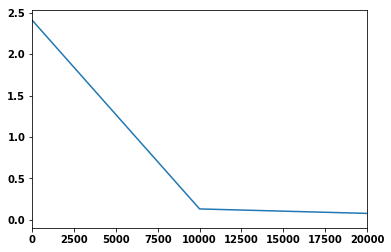

In [120]:
num_steps = 200000
s=[]
los=[]
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10000 == 0):
      s.append(step)
      los.append(l)
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print('final Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
plt.plot(s,los)
plt.xlim([0,20000])

(0, 200000)

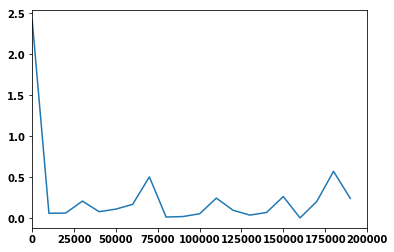

In [117]:
plt.plot(s,los)
plt.xlim([0,200000])